In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2

palette = ['#00777F', '#5BABF5', '#AADEFE', '#EAAC9F', '#8AA0AF']
sns.set_theme(context='notebook', palette=palette, style='darkgrid')

# Suppress the FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
df = pd.read_csv("/content/creditcard.csv")

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [14]:
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

The dataset has 120901 rows and 31 columns.


In [15]:
df.Class.value_counts()

,count
Class,
0.0,120651
1.0,249


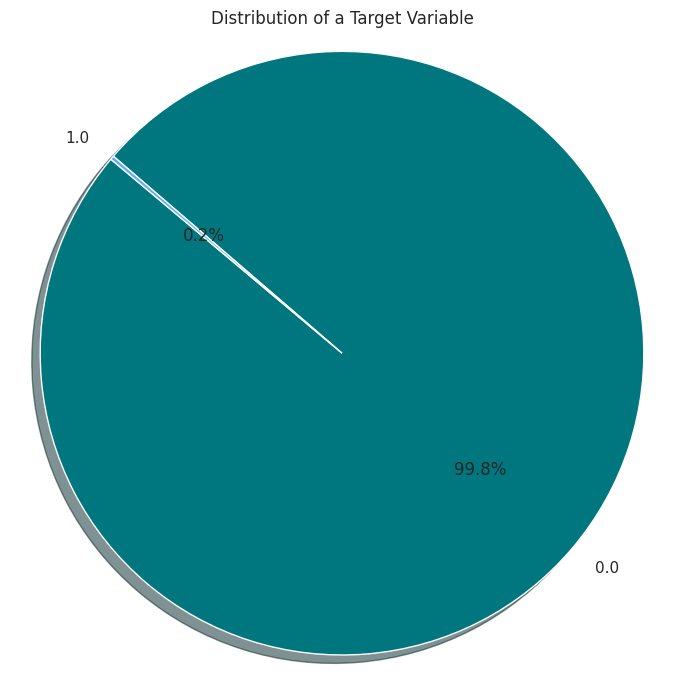

In [6]:
status_counts = df.Class.value_counts()


plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%',
        startangle=140, colors=palette, shadow=True)

plt.title('Distribution of a Target Variable')
plt.axis('equal')

# Display the chart
plt.tight_layout()
plt.show()

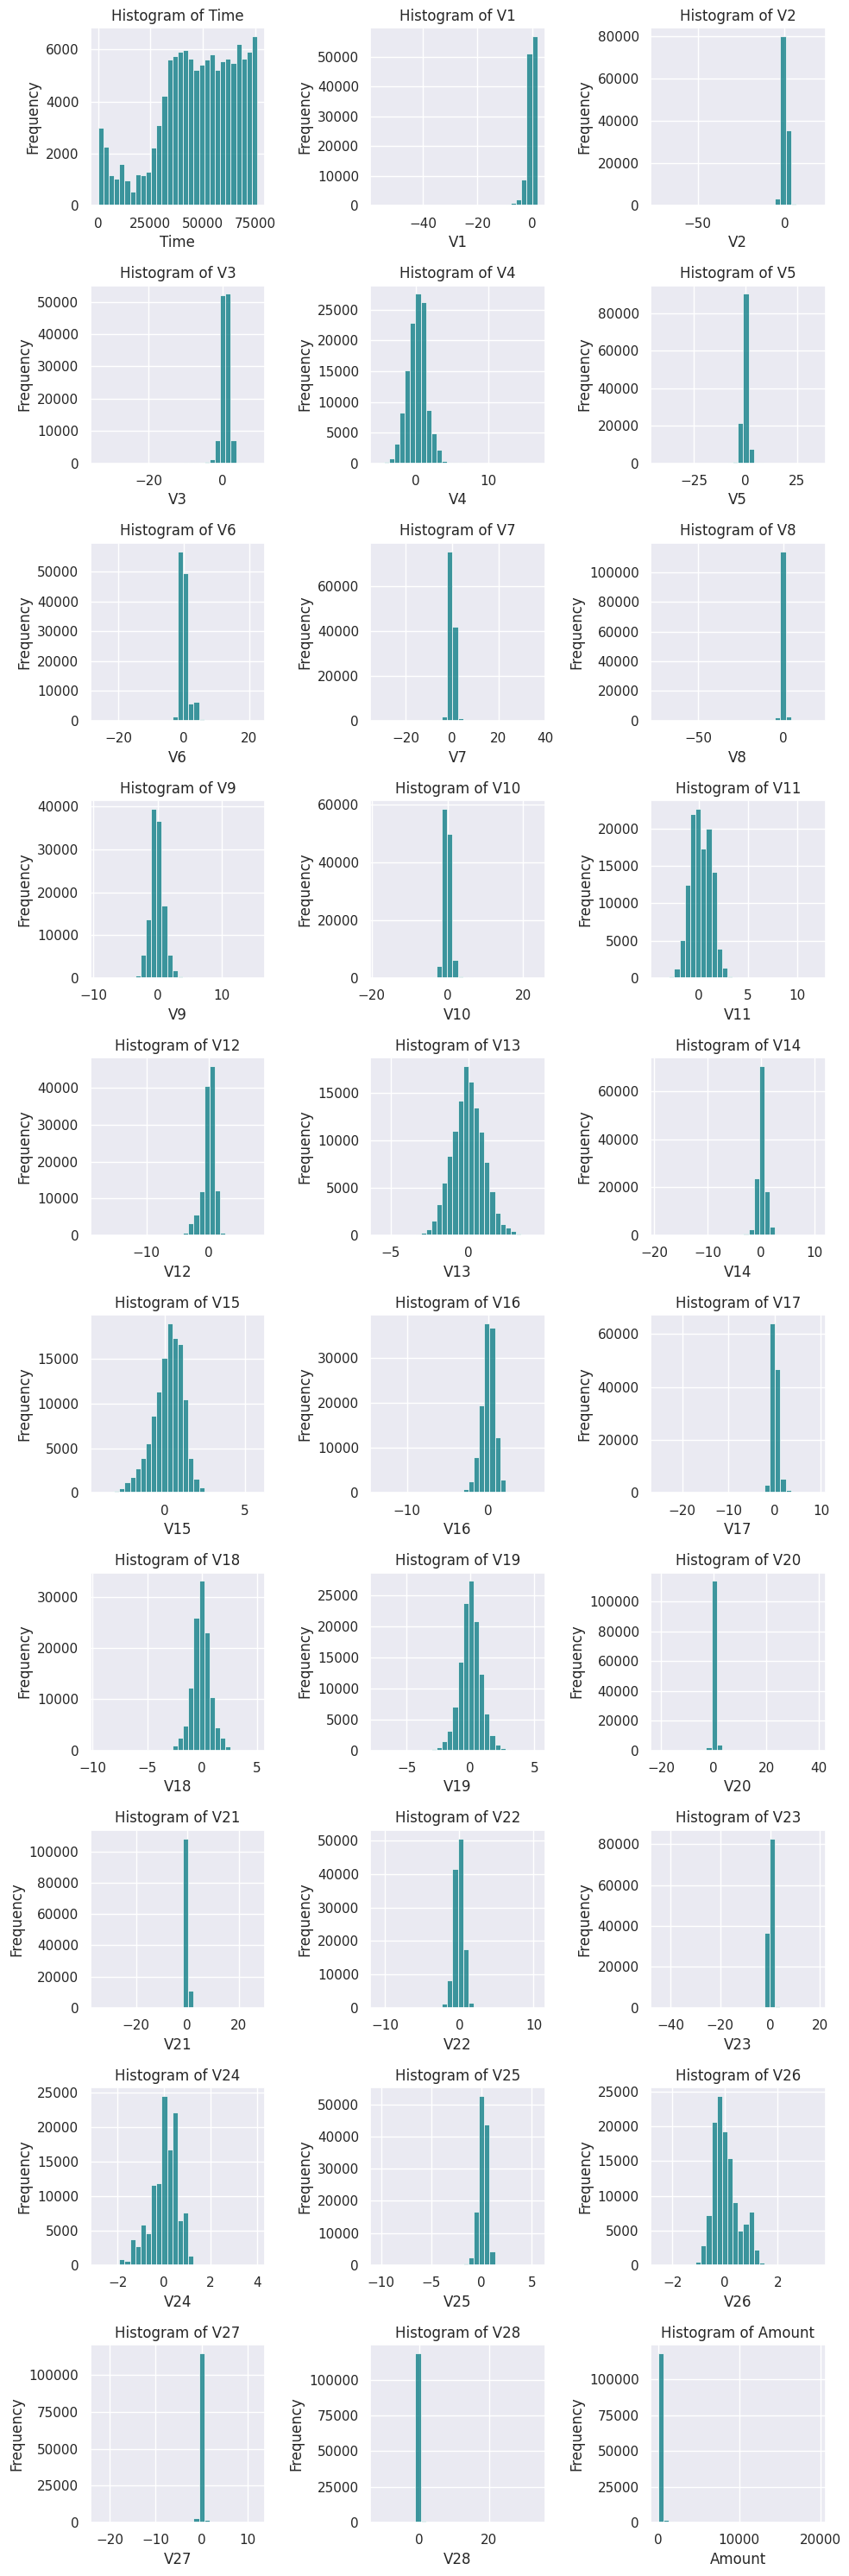

In [7]:
features = df.columns[:-1]

fig, axes = plt.subplots(10, 3, figsize=(10, 30))


axes = axes.flatten()


for i, feature in enumerate(features):
    sns.histplot(df[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'Histogram of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')


for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [8]:
df_transformed = df.copy()

def log_transform_skewed(column):

    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

skewness_before = df.skew()


for col in features:
    if abs(df[col].skew()) > 0.75:
        df_transformed[col] = log_transform_skewed(df[col])


skewness_after = df_transformed.skew()


skewness_comparison = pd.DataFrame({
    'Skewness Before': skewness_before,
    'Skewness After': skewness_after
})


skewness_comparison

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Skewness Before,Skewness After
Time,-0.609033,-0.609033
V1,-3.782407,-0.403118
V2,-4.772480,-0.360633
V3,-5.107907,-1.236661
V4,0.301717,0.301717
V5,-0.951377,0.433146
V6,1.225972,0.711274
V7,-0.935577,-0.041768
V8,-9.069454,-1.088967
V9,0.703375,0.703375


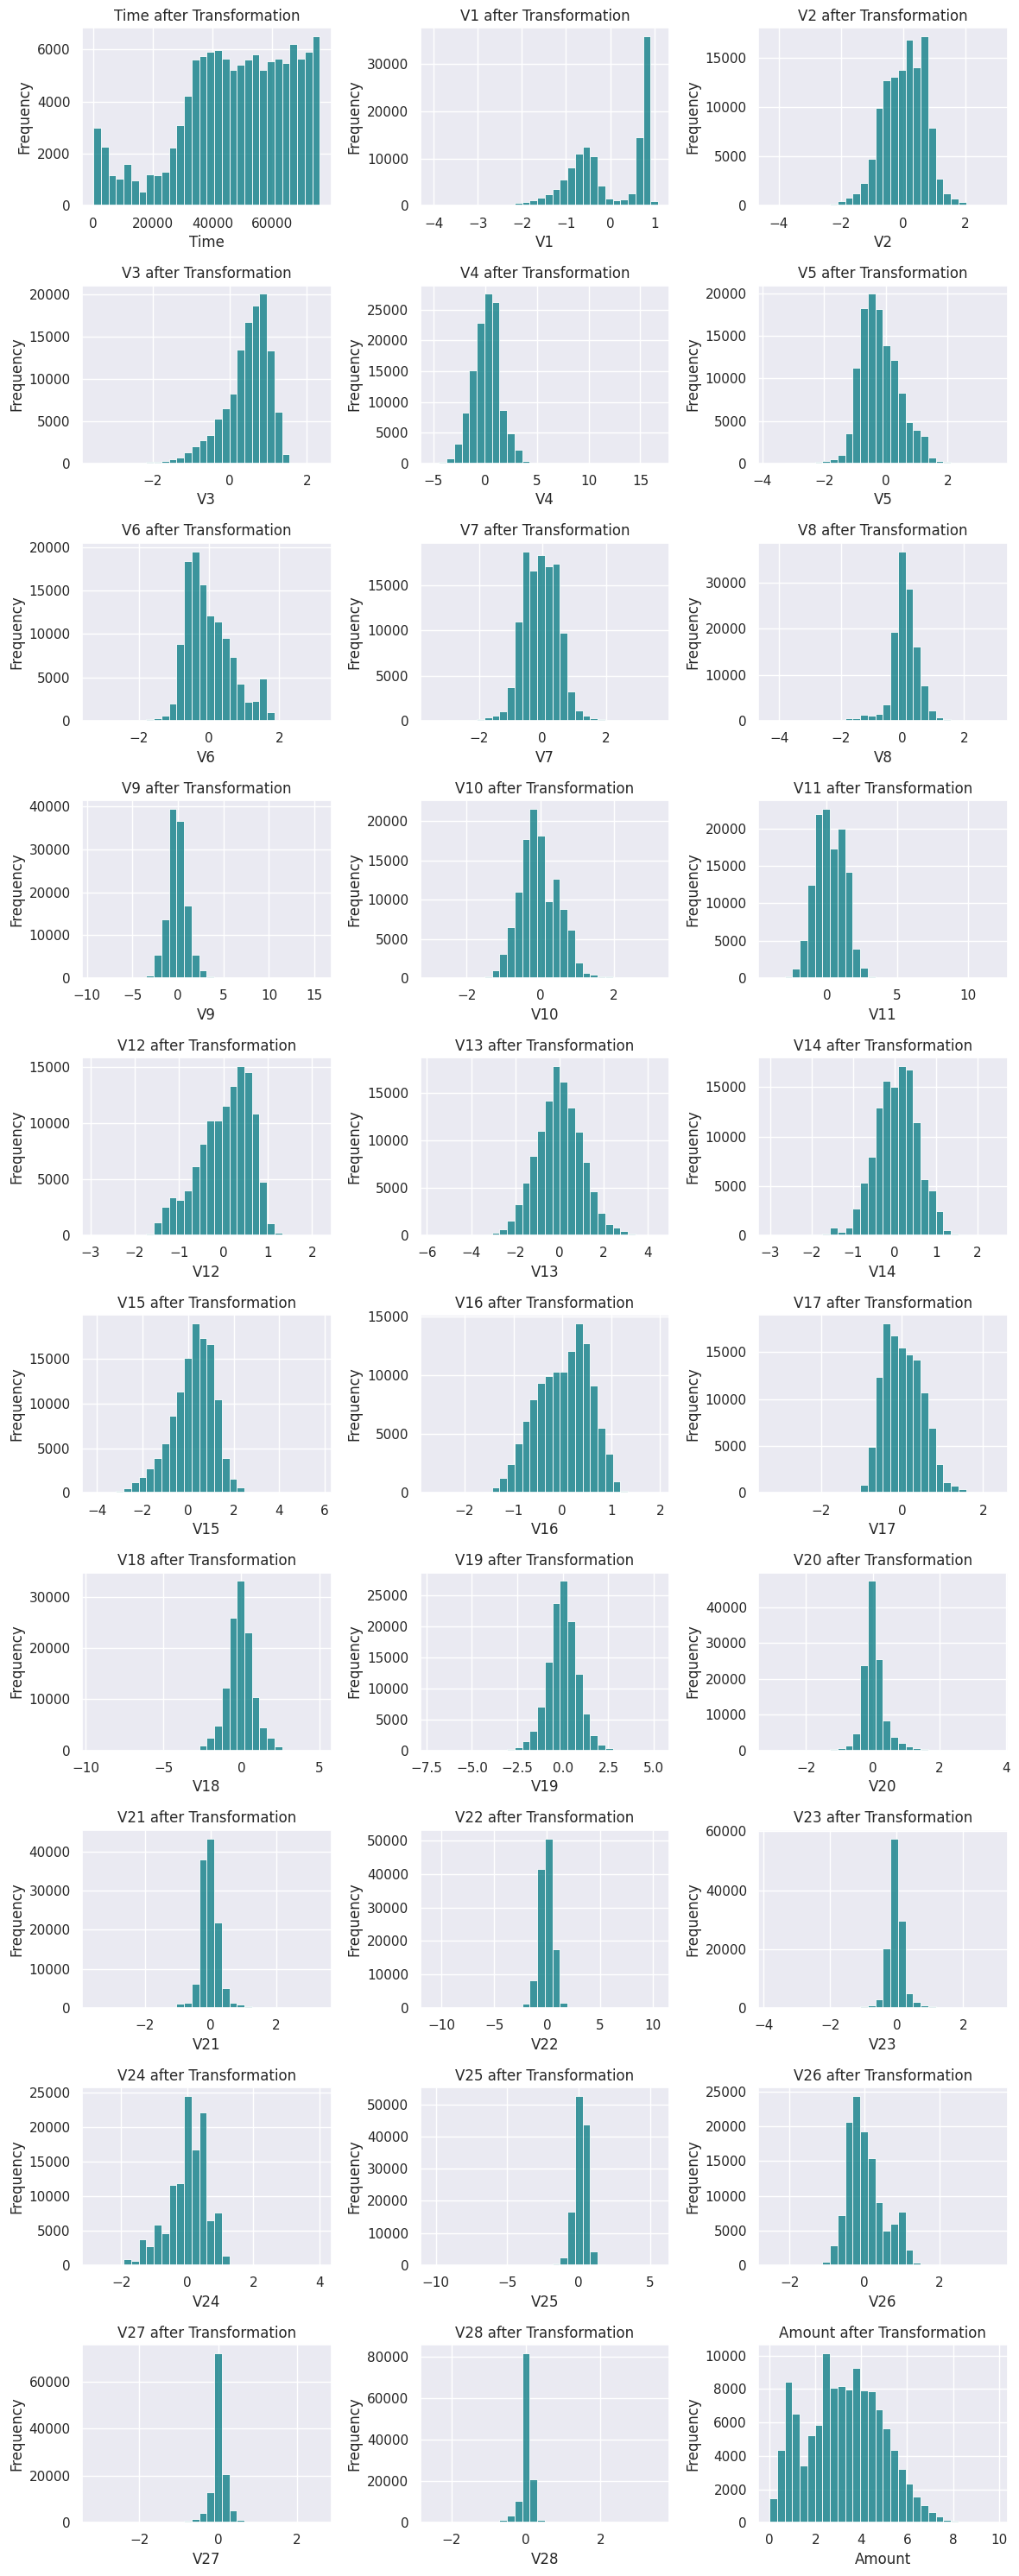

In [11]:

fig, axes = plt.subplots(10, 3, figsize=(12, 30))


axes = axes.flatten()


for i, feature in enumerate(features):
    sns.histplot(df_transformed[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'{feature} after Transformation')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')


for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

if df_transformed.Class.isnull().any():
    print("Target variable 'Class' contains NaN values. Dropping rows with NaN in 'Class'.")
    # Remove rows with NaN values in the target variable
    df_cleaned = df_transformed.dropna(subset=['Class'])
else:
    df_cleaned = df_transformed

# Define features and target variable
X = df_cleaned[features]
y = df_cleaned.Class

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Target variable 'Class' contains NaN values. Dropping rows with NaN in 'Class'.


In [17]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.05, random_state=101)

iso_preds = iso_forest.fit_predict(X_scaled)


iso_preds = [1 if x == -1 else 0 for x in iso_preds]


print(classification_report(y, iso_preds))
roc_auc = roc_auc_score(y, iso_preds)
print("ROC AUC Score: ", roc_auc)

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98    120651
         1.0       0.04      0.87      0.07       249

    accuracy                           0.95    120900
   macro avg       0.52      0.91      0.52    120900
weighted avg       1.00      0.95      0.97    120900

ROC AUC Score:  0.911590664820058


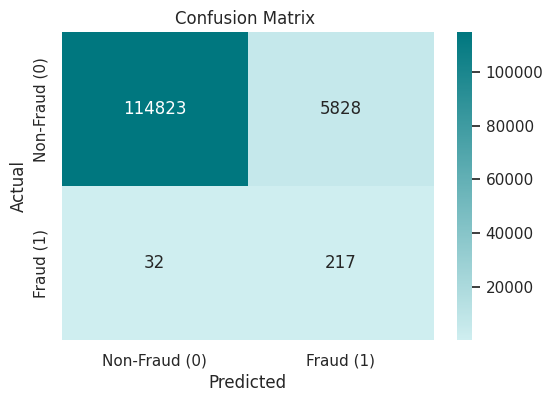

In [19]:
colors = ['#CFEEF0', '#00777F']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

cm = confusion_matrix(y, iso_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [18]:
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))

    # Encoder
    encoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(encoded)
    encoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(encoded)


    latent = Dense(4, activation='relu')(encoded)

    # Decoder
    decoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(latent)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    decoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

autoencoder = build_autoencoder(X_scaled.shape[1])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

X_train = X_scaled[y == 0]
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

reconstructed = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)


threshold = np.percentile(mse, 90)
autoen_preds = np.where(mse > threshold, 1, 0)

print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)

Epoch 1/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 1.0451 - val_loss: 0.9270
Epoch 2/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.9307 - val_loss: 0.8635
Epoch 3/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.8857 - val_loss: 0.8313
Epoch 4/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.8577 - val_loss: 0.8144
Epoch 5/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.8490 - val_loss: 0.7988
Epoch 6/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.8375 - val_loss: 0.7838
Epoch 7/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.8196 - val_loss: 0.7692
Epoch 8/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.8048 - val_loss: 0.7583
Epoch 9/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.7999 - val_loss: 0.7491
Epoch 10/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7863 - val_loss: 0.7422
Epoch 11/50
3394/3394 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.7865 - val_loss: 0.7400
Epoch 12/50
3394/3394 ━

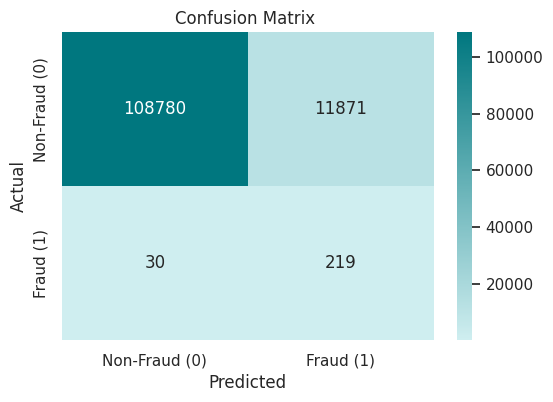

In [20]:
# Plot the confusion matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap=custom_cmap, fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()